In [1]:
%load_ext lab_black
# Import important tools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.io import loadmat, savemat
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit, minimize, least_squares
from scipy.integrate import trapz
from scipy.stats import norm, kurtosis
from matplotlib.ticker import ScalarFormatter
from matplotlib import rc

In [2]:
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["lines.markeredgecolor"] = "k"
mpl.rcParams["lines.markeredgewidth"] = 1
mpl.rcParams["figure.dpi"] = 130
rc("font", family="serif")
rc("text", usetex=True)
rc("xtick", labelsize="x-small")
rc("ytick", labelsize="x-small")


def cm2inch(value):
    return value / 2.54

We load the data

In [3]:
raw_data = loadmat(
    "fit_result_dur_27052020_n_r_fix_0p0513_wav_532_r_1p516_n_1.597.mat"
)["data"][:, 0:3]
r = 1.516 * 1e-6
n_part = 1.597
fps = 60
time = np.arange(0, np.shape(raw_data)[0]) / fps
dataset = {}
dataset["r"] = r
dataset["n"] = n_part
dataset["fps"] = fps
dataset["time"] = time

# Data exploration


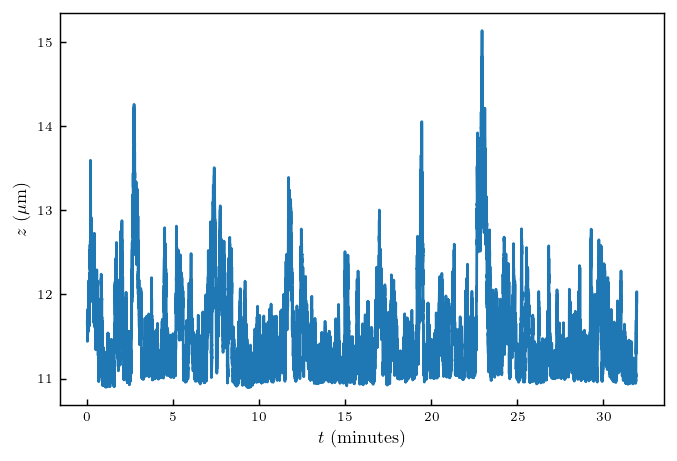

In [4]:
# We put everything in microns
raw_data_m = raw_data
raw_data_m[:, 0:3] = raw_data_m[:, 0:3] * 0.0513
plt.plot(time / fps, raw_data_m[:, 2])
x = raw_data_m[:, 0]
y = raw_data_m[:, 1]
z = raw_data_m[:, 2]

plt.xlabel("$t$ (minutes)")
plt.ylabel("$z$ ($\mathrm{\mu m}$)")
plt.show()

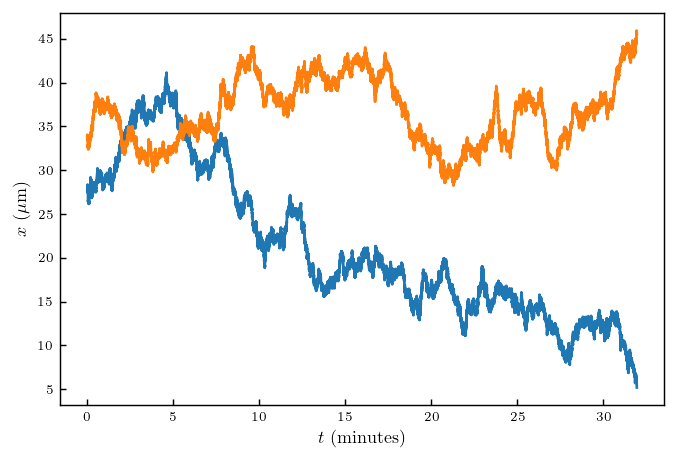

In [5]:
plt.plot(time / fps, raw_data_m[:, 0], label="x")
plt.plot(time / fps, raw_data_m[:, 1], label="y")
plt.xlabel("$t$ (minutes)")
plt.ylabel("$x$ ($\mathrm{\mu m}$)")
plt.show()

# MSD

We compute the MSD using the formula:

\begin{equation}
	\langle\Delta r_i(t)^2 \rangle_t = \langle[r_i(t+\Delta t) - r_i(t)]^2\rangle_t\ .
	\label{MSDdef}
\end{equation}



In [6]:
def MSD(x, t):
    MSD = np.zeros(len(t))
    for n, i in enumerate(t):
        MSD[n] = np.nanmean((x[0:-i] - x[i:]) ** 2)
    return MSD

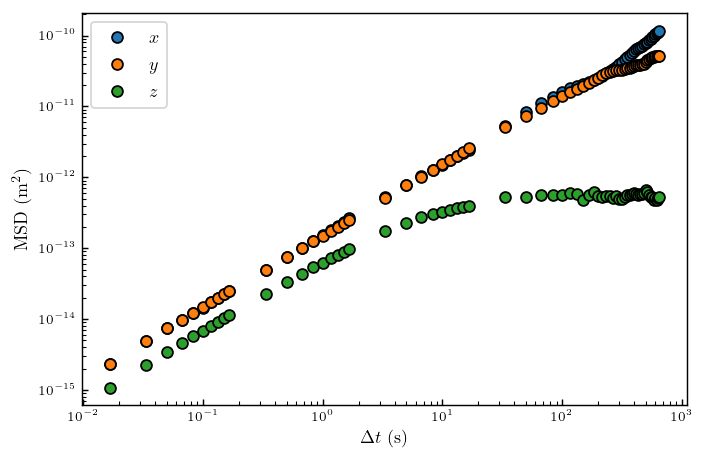

In [7]:
t = np.array(
    [
        *np.arange(1, 10, 1),
        *np.arange(10, 100, 10),
        *np.arange(100, 1000, 100),
        *np.arange(1000, 40000, 1000),
    ]
)
MSD_x = MSD(x * 1e-6, t)  # m² conversion
MSD_y = MSD(y * 1e-6, t)
MSD_z = MSD(z * 1e-6, t)


plt.loglog(time[t], MSD_x, "o", label="$x$")
plt.plot(time[t], MSD_y, "o", label="$y$")
plt.plot(time[t], MSD_z, "o", label="$z$")
plt.ylabel("MSD ($\mathrm{m^2}$)")
plt.xlabel("$\Delta t$ (s)")

plt.legend()

dataset["MSD_x_tot"] = MSD_x
dataset["MSD_y_tot"] = MSD_y
dataset["MSD_z_tot"] = MSD_z
dataset["MSD_time_tot"] = time[t]

We fit the short time MSD with and average diffusion coefficient such as:

\begin{equation}
	\langle\Delta r_i(t)^2 \rangle_t = 2 \langle D_i \rangle \Delta t\ ,
	\label{averagediff}
\end{equation}


In [8]:
Do = 4e-21 / (6 * np.pi * 0.001 * r)
f = lambda x, a, noiselevel: 2 * Do * a * x + (noiselevel * 1e-9) ** 2
popt_1, pcov_1 = curve_fit(f, time[t[0:5]], MSD_x[0:5], p0=[1, 30])
popt_2, pcov_1 = curve_fit(f, time[t[0:5]], MSD_y[0:5], p0=[1, 30])
popt_3, pcov_1 = curve_fit(f, time[t[0:5]], MSD_z[0:5], p0=[1, 30])

dataset["x_MSD_fit"] = time[t[0:5]]

dataset["MSD_x"] = MSD_x[0:5]
dataset["MSD_y"] = MSD_y[0:5]
dataset["MSD_z"] = MSD_z[0:5]

C:\Users\m.lavaud\.conda\envs\analyse\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [9]:
print(
    "We measure a reduced mean diffusion coefficient of {:.3f} for the perpendicular motion and of {:.3f} for the parallel motion".format(
        (popt_1[0] + popt_2[0]) / 2, popt_3[0]
    )
)

We measure a reduced mean diffusion coefficient of 0.522 for the perpendicular motion and of 0.243 for the parallel motion


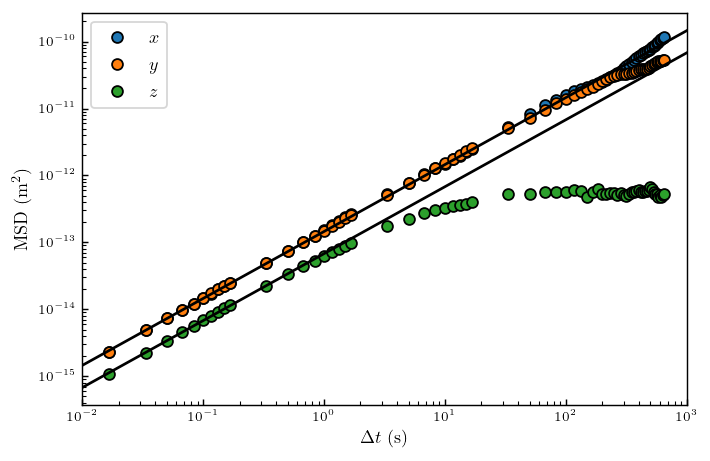

In [10]:
plt.loglog(time[t], MSD_x, "o", label="$x$")
plt.plot(time[t], MSD_y, "o", label="$y$")
plt.plot(time[t], MSD_z, "o", label="$z$")
plt.ylabel("MSD ($\mathrm{m^2}$)")
plt.xlabel("$\Delta t$ (s)")
tt = np.linspace(1e-2, 1e3)
plt.plot(tt, f(tt, *popt_1), color="k")
plt.plot(tt, f(tt, *popt_3), color="k")

plt.xlim((1e-2, 1e3))
plt.legend()

# Displacement distributions

## $\Delta x$ distributions

In [11]:
def pdf(data, bins=10, density=True):
    """
    function to automatize the computations of experimental probability density functions.
    """

    pdf, bins_edge = np.histogram(data, bins=bins, density=density)
    bins_center = (bins_edge[0:-1] + bins_edge[1:]) / 2

    return pdf, bins_center

Text(0.5, 0, '$\\Delta x$ [$\\mathrm{\\mu m}$]')

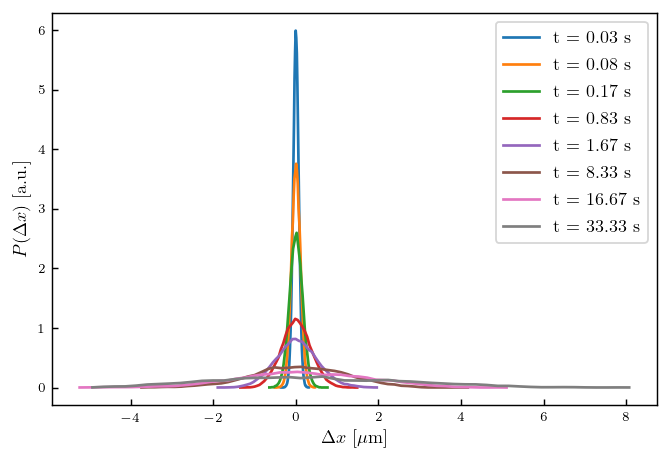

In [12]:
I = [2, 5, 10, 50, 100, 500, 1000, 2000]

for i in I:

    Dezs = x[0:-i] - x[i:]
    hist, bins_center = pdf(Dezs, bins=50)

    plt.plot(bins_center, hist, label=" t = {:.2f} s".format(time[i]))

plt.legend()
plt.ylabel("$P(\Delta x)$ [a.u.]")
plt.xlabel("$\Delta x$ [$\mathrm{\mu m}$]")



If we now normalize by the standard deviation


In [13]:
def gauss_function(x, a, x0, sigma):
    return a * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))

Text(0.5, 0, 'normalized $\\Delta x$ [a.u.]')

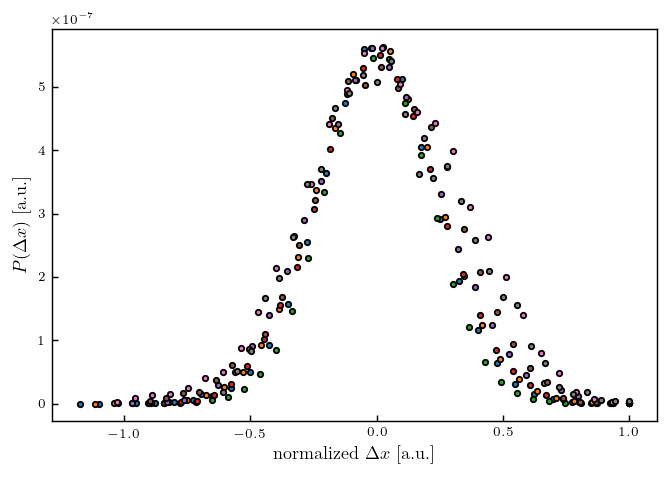

In [14]:
for n, i in enumerate(I):

    Dezs = x[0:-i] - x[i:]
    Dezs = Dezs / np.sqrt(2 * Do * time[i])
    hist, bins_center = pdf(Dezs, bins=30)

    # if i == I[0]:
    #    popt, pcov = curve_fit(gauss_function, bins_center/np.max(bins_center), hist, p0 = [1, np.mean(hist), np.std(hist)])
    #    plt.plot(bins_center/np.max(bins_center), gauss_function(bins_center, *popt), label = "fit at t = {:.2f} s".format(time[i]))
    #    plt.plot(bins_center/np.max(bins_center), hist, "x",label = " t = {:.2f} s".format(time[i]),color = "tab:blue")
    #    continue

    plt.plot(
        bins_center / np.max(bins_center),
        hist,
        ".",
        label=" $Delta$t = {:.2f} s".format(time[i]),
    )


plt.ylabel("$P(\Delta x)$ [a.u.]")
plt.xlabel("normalized $\Delta x$ [a.u.]")

In [15]:
(3.5e-22) ** (1 / 3)

7.047298732064899e-08

We can see a clear change but we would need to average on different trajectectories to have consitant results.

## $\Delta z$ distributions


Text(0.5, 0, '$\\Delta x$ [$\\mathrm{\\mu m}$]')

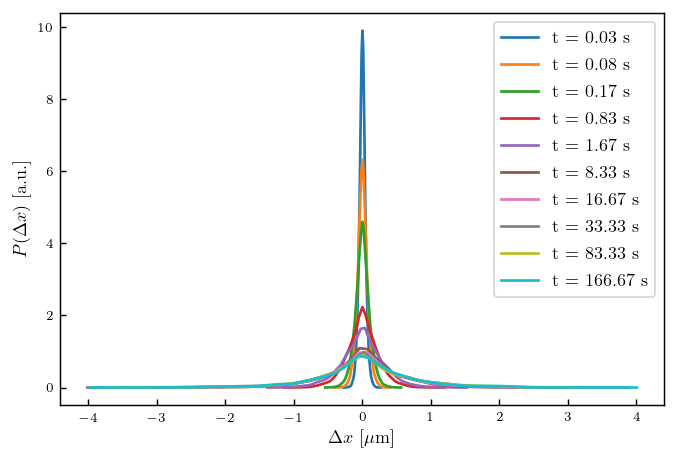

In [16]:
I = [2, 5, 10, 50, 100, 500, 1000, 2000, 5000, 10000]

for i in I:

    Dezs = z[0:-i] - z[i:]
    hist, bins_center = pdf(Dezs[~np.isnan(Dezs)], bins=50)

    plt.plot(bins_center, hist, label=" t = {:.2f} s".format(time[i]))

plt.legend()
plt.ylabel("$P(\Delta x)$ [a.u.]")
plt.xlabel("$\Delta x$ [$\mathrm{\mu m}$]")

Text(0.5, 0, '$\\Delta x$ [$\\mathrm{\\mu m}$]')

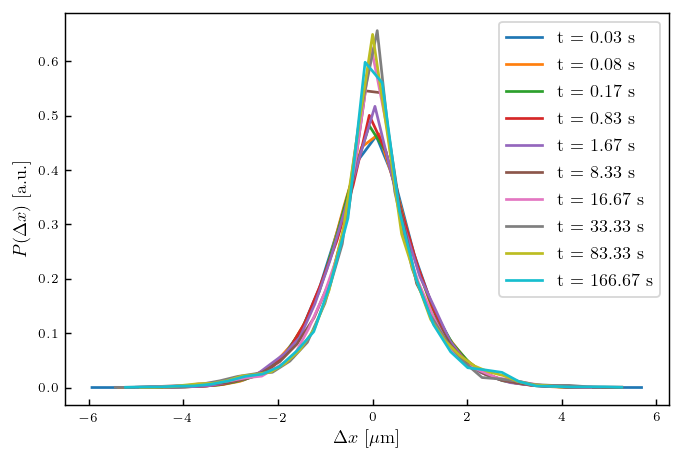

In [17]:
for i in I:

    Dezs = z[0:-i] - z[i:]
    Dezs = Dezs / np.nanstd(Dezs)
    hist, bins_center = pdf(Dezs[~np.isnan(Dezs)], bins=30)

    plt.plot(bins_center, hist, label=" t = {:.2f} s".format(time[i]))

plt.legend()
plt.ylabel("$P(\Delta x)$ [a.u.]")
plt.xlabel("$\Delta x$ [$\mathrm{\mu m}$]")



### Short time distributions

(1e-05, 1)

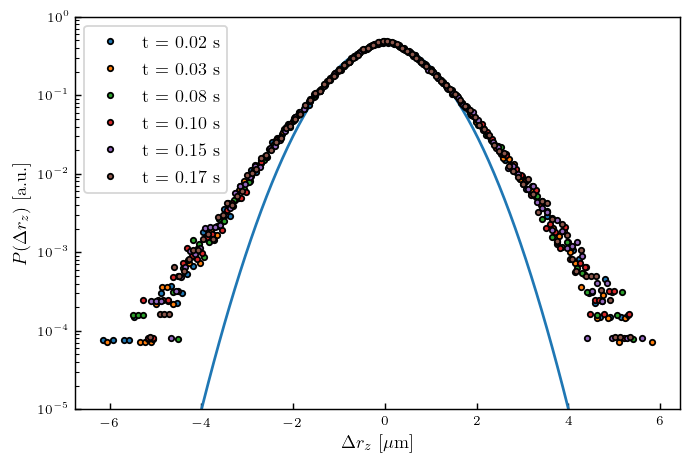

In [18]:
I = [1, 2, 5, 6, 9, 10]

for i in I:

    Dezs = z[0:-i] - z[i:]
    Dezs = Dezs / np.std(Dezs)
    hist, bins_center = pdf(Dezs[~np.isnan(Dezs)], bins=100)

    if i == I[0]:
        popt, pcov = curve_fit(
            gauss_function, bins_center, hist, p0=[1, np.mean(hist), np.std(hist)]
        )
        plt.plot(bins_center, gauss_function(bins_center, *popt))
        plt.plot(
            bins_center,
            hist,
            ".",
            label=" t = {:.2f} s".format(time[i]),
            color="tab:blue",
        )
        continue
    plt.semilogy(bins_center, hist, ".", label=" t = {:.2f} s".format(time[i]))

plt.legend()
plt.ylabel("$P(\Delta r_z)$ [a.u.]")
plt.xlabel("$\Delta r_z$ [$\mathrm{\mu m}$]")
axes = plt.gca()
axes.set_ylim([1e-5, 1])

The non-Gaussianity is due to the hindered mobility. Taking into account the hindered mobility the PDF of displacement writes:

\begin{equation} P(\Delta r_i , \Delta t) = \int_0 ^\infty \mathrm{d}DP(D_i) \frac{1}{\sqrt{4 \pi D_i \Delta t}} \exp\left[ \frac{-\Delta_i r_i ^2}{4D_i\Delta t} \right]~. \end{equation} 

This non-Gaussianity can be fitted as done at the end of this appendix and shown in the manuscript.



## Long time distributions

Text(0.5, 0, '$\\Delta r_z$ [$\\mathrm{\\mu m}$]')

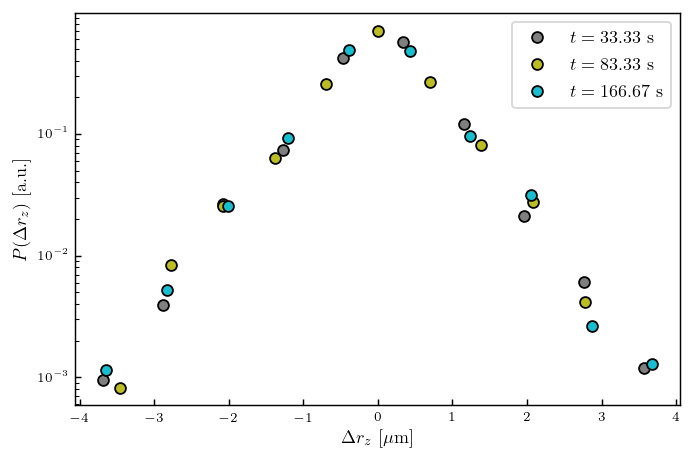

In [19]:
I = [2000, 5000, 10000]

color_long_time = ["tab:gray", "tab:olive", "tab:cyan"]
for n, i in enumerate(I):

    Dezs = z[0:-i] - z[i:]
    hist, bins_center = pdf(Dezs[~np.isnan(Dezs)], bins=10)

    plt.semilogy(
        bins_center,
        hist,
        "o",
        label=" $t = {:.2f}$ s".format(time[i]),
        color=color_long_time[n],
    )

plt.legend()

plt.ylabel("$P(\Delta r_z)$ [a.u.]")
plt.xlabel("$\Delta r_z$ [$\mathrm{\mu m}$]")

Indeed at long time it becomes exponential and it's no longer dependent on $\Delta t$
At very long time intervals $\Delta t$ each position measurement can be seen as random measurement on the Boltzmann distribution. Thus, one can write the probability distribution as a convolution of two PDF: \begin{equation} P(\Delta z) = \int ^ \infty _{- \infty} dz P_B (z)P_B (z + \Delta z), \end{equation} with : \begin{equation} P_B(z) = Ae^{\left(Bexp\left(-\frac{z}{l_d}\right) - \frac{z}{l_b}\right)} \end{equation}
Also, $P_B(z < 0)$ giving at long time step : \begin{equation} P(\Delta z) = A'exp \left[Bexp\left[-\frac{z}{l_d}\right] (1 + exp[- \frac{\Delta z}{ l_d}]) - \frac{ 2z + \Delta z}{l_b} \right] \end{equation}


## Analysis of pdf of the $\Delta z$ at large time step

To have a better measurement we average the PDF of displacement $\Delta r_z$ over different time-step $\Delta t$ . But, first of all, we need to get rid of the drifts at long time. We do that by taking a moving minimum. 



## Dedrifting the z trajectory

In [20]:
def movmin(datas, k):
    result = np.empty_like(datas)
    start_pt = 0
    end_pt = int(np.ceil(k / 2))

    for i in range(len(datas)):
        if i < int(np.ceil(k / 2)):
            start_pt = 0
        if i > len(datas) - int(np.ceil(k / 2)):
            end_pt = len(datas)
        result[i] = np.min(datas[start_pt:end_pt])
        start_pt += 1
        end_pt += 1

    return result

In [21]:
z_dedrift = z - movmin(z, 10000)

Text(0, 0.5, 'z [$\\mathrm{\\mu m}$]')

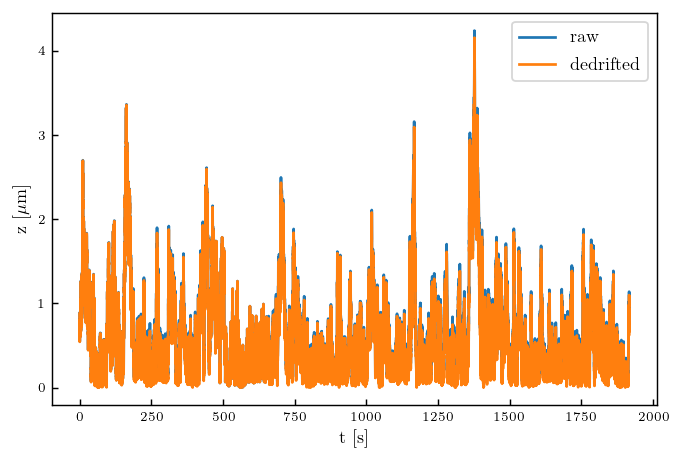

In [22]:
# Fig for comparing the two

plt.plot(time, z - np.min(z), label="raw")
plt.plot(time, z_dedrift, label="dedrifted")
plt.legend()

plt.xlabel("t [s]")
plt.ylabel("z [$\mathrm{\mu m}$]")

###  Measuring pdf at large $\Delta t$  with the dedrifted trajectory and analysing it

In [23]:
t_start = 25
t_end = 30
I = np.arange(t_start * fps, t_end * fps)
bins = 50

hists = np.zeros((bins, len(I)))
bins_centers = np.zeros((bins, len(I)))

for n, i in enumerate(I):

    Dezs = z_dedrift[0:-i] - z_dedrift[i:]
    hist, bins_center = pdf(Dezs[~np.isnan(Dezs)], bins=bins)

    hists[:, n] = hist
    bins_centers[:, n] = bins_center


pdf_long_t = np.mean(hists, axis=1)
bins_centers_long_t = np.mean(bins_centers, axis=1)
err_long_t = np.std(hists, axis=1)
err_bins_centers = np.std(bins_centers, axis=1)

Text(0.5, 0, '$\\Delta x$ ($\\mathrm{\\mu m}$)')

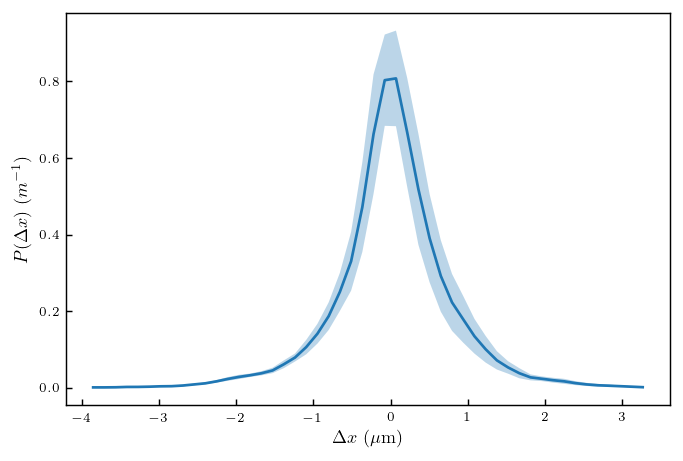

In [24]:
plt.plot(bins_centers_long_t, pdf_long_t)
plt.fill_between(
    bins_centers_long_t, pdf_long_t - err_long_t, pdf_long_t + err_long_t, alpha=0.3
)
plt.ylabel("$P(\Delta x)$ ($m^{-1}$)")
plt.xlabel("$\Delta x$ ($\mathrm{\mu m}$)")



We are now going to code the function
\begin{equation} P(\Delta z) = \int ^ \infty _{- \infty}A'exp \left[Bexp\left[-\frac{z}{l_d}\right] (1 + exp[- \frac{\Delta z}{ l_d}]) - \frac{ 2z + \Delta z}{l_b} \right] \end{equation}

Noting that coding the form :
\begin{equation} P(\Delta z) = \int ^ \infty _{- \infty} dz P_B (z)P_B (z + \Delta z), \end{equation}

Will be easier and $P_B$ will be reused later on. Also since $P_B(z < 0) = 0$ :
\begin{equation} P(\Delta z) = \int ^ \infty _{0} dz P_B (z)P_B (z + \Delta z), \end{equation}

with :
\begin{equation} P_B(z) = Ae^{\left(Bexp\left(-\frac{z}{l_d}\right) - \frac{z}{l_b}\right)} \end{equation}


In [25]:
def P_b(z, A, B, ld, lb):
    P_b = A * np.exp(-B * np.exp(-z / (ld)) - z / lb)
    P_b[z < 0] = 0
    return P_b


def dPdeltaz_long(z, DZ, A, B, ld, lb):
    return P_b(z, A, B, ld, lb) * P_b(z + DZ, A, B, ld, lb)


def P_computation(DZ, A, B, ld, lb):
    z = np.linspace(0, 20e-6, 1000)
    dP = dPdeltaz_long(z, DZ, A, B, ld, lb)
    P = trapz(dP, z)
    return P


def Pdeltaz_long(DZ, B, ld, lb):
    if type(DZ) == float:
        return P_computation(i, 1, B, ld, lb)

    pdf = np.array([P_computation(i, 1, B, ld * 1e-9, lb * 1e-9) for i in DZ])

    # normalisation of the PDF to not use A

    A = trapz(pdf, DZ * 1e6)

    return np.array([P_computation(i, 1, B, ld * 1e-9, lb * 1e-9) for i in DZ]) / A

In [26]:
A = 0.14e8
B = 4
ld = 70
lb = 500
p1 = [B, ld, lb]

# Normalisation fo the pdf

pdf_long_t = pdf_long_t / trapz(pdf_long_t, bins_centers_long_t)


popt, pcov = curve_fit(Pdeltaz_long, bins_centers_long_t * 1e-6, pdf_long_t, p0=p1)
dataset["pdf_longtime"] = pdf_long_t
dataset["x_pdf_longtime"] = bins_centers_long_t * 1e-6

<ipython-input-25-d08630fe76fc>:2: RuntimeWarning: overflow encountered in exp
  P_b = A * np.exp(-B * np.exp(-z / (ld)) - z / lb)


Text(0.5, 0, '$\\Delta z$ [$\\mathrm{\\mu m}$]')

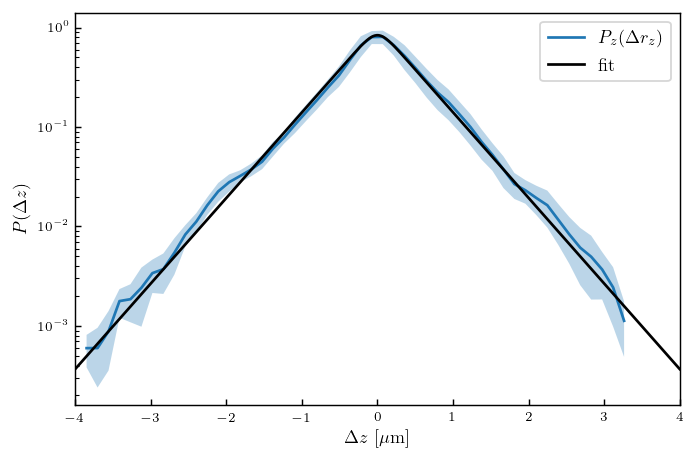

In [27]:
A = 0.14e8
B = 400
ld = 70
lb = 500
p0 = [B, ld, lb]


plt.semilogy(bins_centers_long_t, pdf_long_t, label="$P_z(\Delta r_z)$")
plt.fill_between(
    bins_centers_long_t, pdf_long_t - err_long_t, pdf_long_t + err_long_t, alpha=0.3
)

zz = np.linspace(-4, 4, 1000)
plt.plot(zz, Pdeltaz_long(zz * 1e-6, *popt), label="fit", color="k")
plt.xlim(-4, 4)
plt.legend()
plt.ylabel("$P(\Delta z)$")
plt.xlabel("$\Delta z$ [$\mathrm{\mu m}$]")

In [28]:
print("We measure, B = {:.2f}, ld = {:.2f} nm, lb = {:.2f} nm".format(*popt))
B, ld, lb = popt

We measure, B = 20.71, ld = 71.84 nm, lb = 504.78 nm


## Analyse of the MSD z plateau

Text(0.5, 0, '$\\Delta$t (s)')

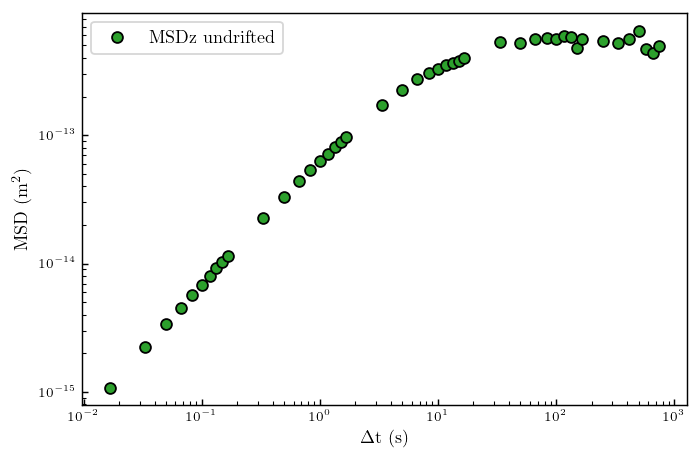

In [29]:
t = np.concatenate(
    (
        np.arange(1, 10, 1),
        np.arange(10, 100, 10),
        np.arange(100, 1000, 100),
        np.arange(1000, 10000, 1000),
        np.arange(10000, 50000, 5000),
    )
)

MSD_z_dedrift = MSD(z_dedrift * 1e-6, t)

plt.loglog(time[t], MSD_z_dedrift, "o", label="MSDz undrifted", color="tab:green")
plt.legend()
plt.ylabel("MSD (m$^2$)")
plt.xlabel("$\Delta$t (s)")

In [30]:
plateau = np.mean(MSD_z_dedrift[time[t] > 1e2])

Text(0.5, 0, '$\\Delta$t (s)')

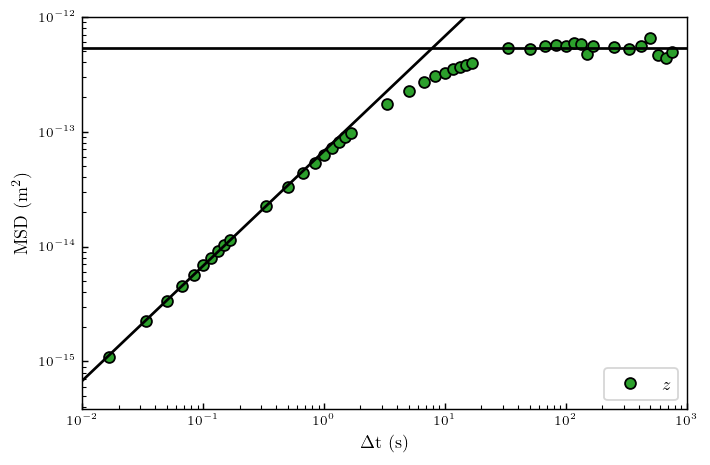

In [31]:
plt.loglog(time[t], MSD_z_dedrift, "o", label="$z$", color="tab:green")
plt.plot(tt, [plateau] * len(tt), "k")
plt.plot(tt, f(tt, *popt_3), color="k")
plt.xlim((1e-2, 1e3))
plt.ylim((None, 1e-12))
plt.legend()
plt.ylabel("MSD (m$^2$)")
plt.xlabel("$\Delta$t (s)")

In [32]:
np.mean(MSD_z_dedrift[time[t] > 1e2])

5.348018604759325e-13

In [33]:
# dataset["plateau_MSD"] = popt[0]
dataset["plateau_MSD"] = np.mean(MSD_z_dedrift[time[t] > 1e2])
print("Measured plateau : {:e}".format(popt[0]))

Measured plateau : 2.070536e+01


The MSD plateau is theoritically given by:


\begin{equation} 
Plateau = \int _{-\infty} ^{+\infty} \Delta z ^ 2 P_{\Delta z, t \rightarrow +\infty}(\Delta z,B,l_d,l_b) d\Delta z
\end{equation}

In [34]:
x_Th_Plateau = bins_centers_long_t * 1e-6


def Theoritical_Plateau(B, ld, lb):
    x = dataset["x_pdf_longtime"]
    P = Pdeltaz_long(x, B, ld, lb) / trapz(Pdeltaz_long(x, B, ld, lb), x)

    res = trapz((x ** 2) * P, x)
    return res

In [35]:
def minimize_plateau(x):
    B = x[0]
    ld = x[1]
    lb = x[2]
    return (
        np.log(Theoritical_Plateau(B, ld, lb)) - np.log(dataset["plateau_MSD"])
    ) ** 2 / np.log(Theoritical_Plateau(B, ld, lb)) ** 2

In [36]:
res_plateau = minimize(minimize_plateau, x0=[B, ld, lb])
print("We measure, B = {:.2f}, ld = {:.2f} nm, lb = {:.2f} nm".format(*res_plateau.x))

We measure, B = 20.71, ld = 71.84 nm, lb = 504.78 nm



## PDF of heights

In [37]:
def logarithmic_hist(data, begin, stop, num=50, base=2):

    if begin == 0:
        beg = stop / num
        bins = np.logspace(
            np.log(beg) / np.log(base), np.log(stop) / np.log(base), num - 1, base=base
        )
        widths = bins[1:] - bins[:-1]
        bins = np.cumsum(widths[::-1])
        bins = np.concatenate(([0], bins))
        widths = bins[1:] - bins[:-1]

    else:
        bins = np.logspace(
            np.log(begin) / np.log(base), np.log(stop) / np.log(base), num, base=base
        )
        widths = bins[1:] - bins[:-1]

    hist, bins = np.histogram(data, bins=bins, density=True)
    # normalize by bin width
    bins_center = (bins[1:] + bins[:-1]) / 2

    return bins_center, widths, hist

Text(0, 0.5, '$P_z(z)$')

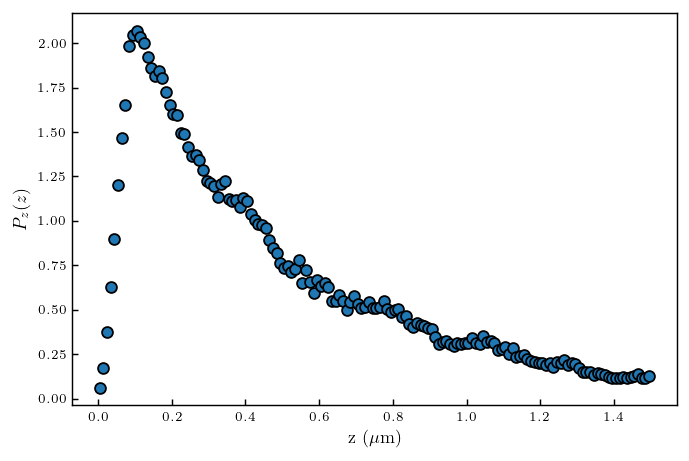

In [38]:
pdf_z, bins_center_pdf_z = pdf(z_dedrift[z_dedrift < 1.5], bins=150)
plt.plot(bins_center_pdf_z, pdf_z, "o")
plt.xlabel("z ($\mathrm{\mu m}$)")
plt.ylabel("$P_z(z)$")



The idea now is to find where the substrate is, to do this we will use a first method which consist to adjust the PDF with an offset to make it fit with the measured mean Diffusion coefficient. With :
\begin{equation} 
< D_i > = \int _{-\infty} ^{\infty} dz D_i(z)P(z) 
\end{equation}

For z we are going to use the Padé approx :
\begin{equation} D_z (z) \approx D_0 \left( \frac{6z^2 + 2rz}{6z^2 + 9rz + 2r^2} \right) \end{equation}

For x we are going to use the Faxen formula :
\begin{equation} D_x (z) \approx D_0 \left[ 1 - \frac{9}{16} \left(\frac{r}{z}\right) + \frac{1}{8} \left(\frac{r}{z}\right)^3 - \frac{45}{236} \left(\frac{r}{z}\right)^4 - \frac{1}{16} \left(\frac{r}{z}\right)^5 \right] \end{equation}

To do this we will fit the PDF with an offset, adjust it with the mean value of z. Let's first do it over z


In [39]:
def P_b_off(z, z_off, B, ld, lb):
    z_off = z_off * 1e-6
    lb = lb * 1e-9
    ld = ld * 1e-9
    z = z - z_off
    P_b = np.exp(-B * np.exp(-z / (ld)) - z / lb)
    P_b[z < 0] = 0

    # Normalization of P_b

    A = trapz(P_b, z * 1e6)
    P_b = P_b / A

    return P_b

In [40]:
# Normalization of the PDF

pdf_z = pdf_z / trapz(pdf_z, bins_center_pdf_z)


p2 = [0, B, ld, lb]

popt, pcov = curve_fit(P_b_off, bins_center_pdf_z * 1e-6, pdf_z, p0=p2)

<ipython-input-39-f5e0b340e678>:6: RuntimeWarning: overflow encountered in exp
  P_b = np.exp(-B * np.exp(-z / (ld)) - z / lb)
<ipython-input-39-f5e0b340e678>:12: RuntimeWarning: invalid value encountered in true_divide
  P_b = P_b / A


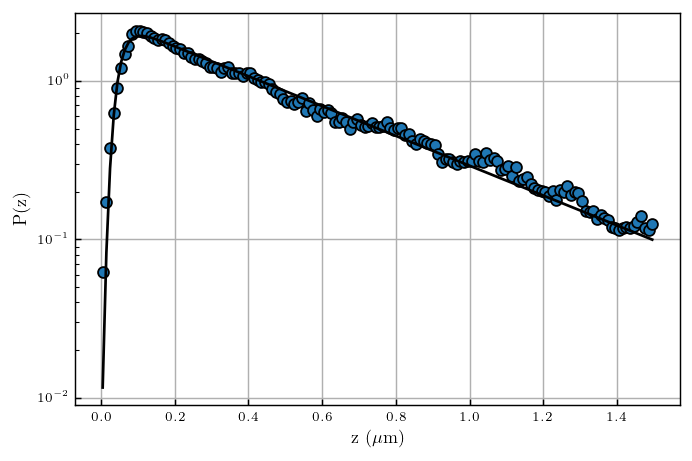

In [41]:
plt.semilogy(bins_center_pdf_z, pdf_z, "o")
plt.plot(bins_center_pdf_z, P_b_off(bins_center_pdf_z * 1e-6, *popt), "k")

plt.xlabel("z $\mathrm{(\mu m)}$")
plt.ylabel("P(z)")
plt.grid()

In [42]:
mean_Dx = (popt_1[0] + popt_2[0]) / 2
mean_Dz = popt_3[0]
print(
    "We measure a mean diffusion coefficient of {:.3f}D0 for the perpendicular motion and of {:.3f}D0 for the parallel motion".format(
        (popt_1[0] + popt_2[0]) / 2, popt_3[0]
    )
)


dataset["D_para"] = mean_Dx
dataset["D_perp"] = mean_Dz

We measure a mean diffusion coefficient of 0.522D0 for the perpendicular motion and of 0.243D0 for the parallel motion


In [43]:
Do = 4e-21 / (6 * np.pi * 0.001 * r)


def Dz_z(z):
    result = (6 * z * z + 2 * r * z) / (6 * z * z + 9 * r * z + 2 * r * r)
    return result


def Dx_z(z):
    result = (
        1
        - 9 / 16 * (r / (z + r))
        + 1 / 8 * (r / (z + r)) ** 3
        - 45 / 256 * (r / (z + r)) ** 4
        - 1 / 16 * (r / (z + r)) ** 5
    )
    return result

In [44]:
def minimizer(z_off):
    Dx_pdf = trapz(
        Dx_z(bins_center_pdf_z * 1e-6)
        * P_b_off(bins_center_pdf_z * 1e-6, z_off, *popt[1:]),
        bins_center_pdf_z,
    )
    Dz_pdf = trapz(
        Dz_z(bins_center_pdf_z * 1e-6)
        * P_b_off(bins_center_pdf_z * 1e-6, z_off, *popt[1:]),
        bins_center_pdf_z,
    )

    return np.abs((1 - mean_Dx / Dx_pdf) + (1 - mean_Dx / Dx_pdf))


res = minimize(minimizer, 0, method="nelder-mead")

In [45]:
offset = res

In [46]:
offset = np.mean(res["final_simplex"][0])
print(
    "From the measurement of the mean diffusion coefficient, we measure an offset of {:.3f} um".format(
        offset
    )
)

From the measurement of the mean diffusion coefficient, we measure an offset of 0.005 um


<ipython-input-39-f5e0b340e678>:6: RuntimeWarning: overflow encountered in exp
  P_b = np.exp(-B * np.exp(-z / (ld)) - z / lb)
<ipython-input-39-f5e0b340e678>:12: RuntimeWarning: invalid value encountered in true_divide
  P_b = P_b / A


Text(0, 0.5, 'P(z)  ($m^{-1}$)')

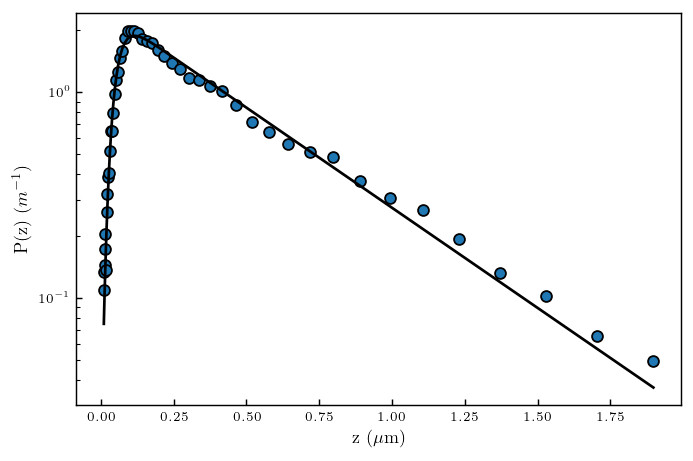

In [47]:
def logarithmic_hist(data, begin, stop, num=50, base=2):
    """
    Function to make logarithmic histograms to have more points
    near the surface and where the particle spend the most of its time.
    """
    if begin == 0:
        beg = stop / num
        bins = np.logspace(
            np.log(beg) / np.log(base), np.log(stop) / np.log(base), num - 1, base=base
        )
        widths = bins[1:] - bins[:-1]
        bins = np.cumsum(widths[::-1])
        bins = np.concatenate(([0], bins))
        widths = bins[1:] - bins[:-1]

    else:
        bins = np.logspace(
            np.log(begin) / np.log(base), np.log(stop) / np.log(base), num, base=base
        )
        widths = bins[1:] - bins[:-1]

    hist, a = np.histogram(data, bins=bins, density=True)
    # normalize by bin width
    bins_center = (bins[1:] + bins[:-1]) / 2

    return bins_center, widths, hist


bins_center_pdf_z, widths, pdf_z = logarithmic_hist(z_dedrift, 0.01, 2, num=50, base=12)

p2 = [0, B, ld, lb]
popt_pdf, pcov_pdf = curve_fit(P_b_off, bins_center_pdf_z * 1e-6, pdf_z, p0=p2)
dataset["pdf_z"] = pdf_z
dataset["x_pdf_z"] = bins_center_pdf_z * 1e-6

plt.semilogy(bins_center_pdf_z, pdf_z, "o")
plt.plot(bins_center_pdf_z, P_b_off(bins_center_pdf_z * 1e-6, *popt_pdf), color="black")

plt.xlabel("z ($\mathrm{\mu m}$)")
plt.ylabel("P(z)  ($m^{-1}$)")

In [48]:
offset_pdf, B_pdf, ld_offset, lb_offset = popt_pdf

We write the diffusion function.

In [49]:
def Dz_z(z, off):
    off = off * 1e-6
    z = z - off
    result = (6 * z * z + 2 * r * z) / (6 * z * z + 9 * r * z + 2 * r * r)
    return result


def Dx_z_off(z, offset):
    offset = offset * 1e-6
    z = z + offset
    result = (
        1
        - 9 / 16 * (r / (z + r))
        + 1 / 8 * (r / (z + r)) ** 3
        - 45 / 256 * (r / (z + r)) ** 4
        - 1 / 16 * (r / (z + r)) ** 5
    )
    return result

## Measuring the diffusion coefficient using the Frishman and Ronceray's method

In [50]:
from scipy.io import loadmat

dataset["D_0"] = 4e-21 / (6 * np.pi * 0.001 * dataset["r"])
D = loadmat("diffusionAnalysis.mat")["diffusion"]
dataset["z_D"] = D[:, 0]
dataset["z_D_x"] = (D[:, 1] + D[:, 2]) / 2
dataset["z_D_z"] = D[:, 3]

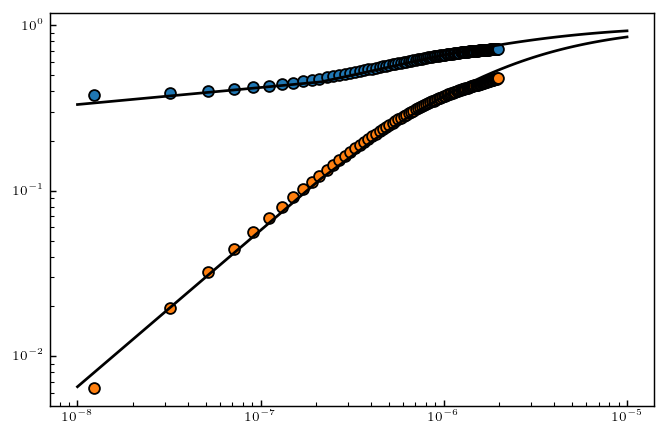

In [51]:
plt.plot(dataset["z_D"], dataset["z_D_x"] / dataset["D_0"], "o")
plt.loglog(dataset["z_D"], dataset["z_D_z"] / dataset["D_0"], "o")

zz = np.linspace(1e-8, 1e-5)
plt.plot(zz, Dz_z(zz, 0), "k")

plt.plot(zz, Dx_z_off(zz, 0), "k")

In [52]:
def c_P_D(B, ld, lb, offset=None):
    if offset == None:
        offset = 0

    z = np.linspace(1e-9, 15e-6, 1000)

    P_D = Dz_z(z, offset) * Do * P_b_off(z, offset, B, ld, lb)

    return Dz_z(z, offset) * Do, P_D / np.trapz(P_D, z)


def _P_Dz_short_time(Dz, Dt, B, ld, lb, offset=None):
    if offset == None:
        offset = 0

    D_z, P_D = c_P_D(B, ld, lb, offset)

    P = np.trapz(
        P_D / np.sqrt(4 * np.pi * D_z * Dt) * np.exp(-(Dz ** 2) / (4 * D_z * Dt)), D_z
    )

    return P


def P_Dz_short_time(Dz, Dt, B, ld, lb, offset=None):
    if offset == None:
        offset = 0

    P = [_P_Dz_short_time(i, Dt, B, ld, lb, offset=offset) for i in Dz]
    P = np.array(P)
    P = P / np.trapz(P, Dz)

    return P


# Fit everything in the same time !

Finaly we can fit everything in the same time to recap we have :

   - MSD x and MSD y => $< D >$
   - MSD z => $< D >$
   - mean $< D >$ with the pdf
   - Long time pdf $\Delta z$ => $l_d,l_b,B$
   - Pdf z => $offset,l_d,l_b, B$
   - D parallel, perp => offset

The minimizer $\chi ^2$ we are going to optimize can be written as :
\begin{equation} \chi^2 = \sum _{n = 1} ^{N} \chi_n^2 \end{equation}\begin{equation} \chi_n^2 = \sum^A(n) _i = 1 \frac{1}{\sigma_{ni}}(y_{ni} - y_n(x_{ni},\boldsymbol{a}))^2 \end{equation}

with $\sigma_{ni}$ the uncertainty (can be set to 1), A the number of point in the dataset for each function, $y_n$, nth equation, $\boldsymbol{a}$ the fit parameters

We have nonlinear functions so we can use the Marquardt to optimize or Nelder-Mead methods to optimize the minimizer.


In [53]:
def minimizer_diffusion_coeff(mean_D_para, mean_D_perp, z_off, B, ld, lb):
    # minimization of the mean diffusion coefficient measurement with the PDF and MSD
    a = trapz(
        Dx_z_off(bins_center_pdf_z * 1e-6, z_off)
        * P_b_off(bins_center_pdf_z * 1e-6, z_off, B, ld, lb),
        bins_center_pdf_z,
    )
    b = trapz(
        Dz_z(bins_center_pdf_z * 1e-6, z_off)
        * P_b_off(bins_center_pdf_z * 1e-6, z_off, B, ld, lb),
        bins_center_pdf_z,
    )
    at = mean_Dx
    bt = mean_Dz
    return (a - at) ** 2 / at ** 2 + (b - bt) ** 2 / bt ** 2


dataset["z"] = z_dedrift
dataset["x"] = x
dataset["y"] = y


def minimizer_Dz_small_t(B, ld, lb):
    xi = 0

    for n, i in enumerate([1, 2, 3]):
        Dezs = (dataset["z"][0:-i] - dataset["z"][i:]) * 1e-6
        Dezs = Dezs  # - np.mean(Dezs)

        hist, bins_center = pdf(Dezs[~np.isnan(Dezs)], bins=30)
        hist = hist / np.trapz(hist, bins_center)

        Dz_th = bins_center
        PPP = P_Dz_short_time(Dz_th, time[i], B, ld, lb)

        # xi = xi + np.nanmean((((np.abs(hist) - (PPP) ) ) ** 2) / ((np.abs(hist)**2)))
        xi = xi + np.nanmean(
            ((hist[hist > 0] - PPP[hist > 0]) ** 2) / hist[hist > 0] ** 2
        )
    return xi

In [54]:
dataset["D_para"] = mean_Dx
dataset["D_perp"] = mean_Dz


def minimizer(x, *args):
    data = dataset
    ld = x[0]
    lb = x[1]
    B = x[2]
    offset_dif = x[3]

    chi_mean_D_pdf = minimizer_diffusion_coeff(
        dataset["D_para"], dataset["D_perp"], 0, B, ld, lb
    )
    chi_MSD_plateau = minimize_plateau([B, ld, lb])

    E_longtime_pdf = (Pdeltaz_long(data["x_pdf_longtime"], B, ld, lb)) - (
        data["pdf_longtime"]
    )
    chi_longtime_pdf = np.mean(
        (E_longtime_pdf[E_longtime_pdf > -np.inf] ** 2)
        / (((Pdeltaz_long(data["x_pdf_longtime"], B, ld, lb))) ** 2)
    )

    E_chi_pdf_z = P_b_off(data["x_pdf_z"], 0, B, ld, lb) - data["pdf_z"]
    chi_pdf_z = np.nanmean(
        (E_chi_pdf_z[E_chi_pdf_z > -np.inf] ** 2)
        / ((P_b_off(data["x_pdf_z"], 0, B, ld, lb)) ** 2)
    )

    E_D_z = (Dz_z(data["z_D"], offset_dif)) - (data["z_D_z"] / Do)
    chi_D_z = np.mean(
        (E_D_z[E_D_z > -np.inf] ** 2) / ((Dz_z(data["z_D"], offset_dif)) ** 2)
    )

    E_D_x = (Dx_z_off(data["z_D"], offset_dif)) - (data["z_D_x"] / Do)
    chi_D_x = np.mean(
        (E_D_x[E_D_x > -np.inf] ** 2) / ((Dx_z_off(data["z_D"], offset_dif)) ** 2)
    )

    chi_Dz_small_t = minimizer_Dz_small_t(B, ld, lb)

    summ = (
        chi_mean_D_pdf
        + chi_MSD_plateau
        + chi_longtime_pdf
        + chi_pdf_z
        + chi_D_z
        + chi_D_x
        + chi_Dz_small_t
    )

    return summ

In [55]:
B = 5
ld = ld_offset
x0 = [ld, 550, B, 0, offset_pdf]

In [56]:
from scipy.optimize import leastsq

options = {
    "maxc1or": 30,
    "ftol": 2.2e-10,
    "gtol": 1e-5,
    "eps": 1e-08,
    "maxfun": 15000,
    "maxiter": 15000,
    "maxls": 20,
    "finite_diff_rel_step": None,
}

res = minimize(
    minimizer,
    x0,
    method="BFGS",
    tol=1e-1,
)

In [57]:
res.x
results = {
    "ld": res.x[0],
    "lb": res.x[1],
    "B": res.x[2],
    "offset_diffusion": res.x[3],
}

results

{'ld': 25.53322987706852,
 'lb': 549.9956782843908,
 'B': 4.856896668800334,
 'offset_diffusion': 0.0019089236000464675}

This final result has been used to plot theories along the manuscript.